In [1]:
import torch
import os
from models.pyramid import build_pyramid_occupancy_network, build_extended_pyramid_occupancy_network
from model import UNET
import torchvision.transforms as transforms
from dataset import NuScenesDataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import cv2
from experiments.ipm.ipm_utilities import ipm_transform
import matplotlib.pyplot as plt
from configs.config_utilities import load_config
from utilities.torch import detect_device

from logger import colorise
import matplotlib.pyplot as plt
from nuscenes_utilities import NUSCENES_CLASS_NAMES, flatten_labels
from torchmetrics import classification, Precision, Recall
import pandas as pd
import math

In [2]:
size = 1
legend_tensor = torch.zeros((15,size,15*size)).long()
for i in range(14):
    legend_tensor[i,:,((i+1)*size):((i+2)*size)] = 1

In [3]:
flatten_labels(legend_tensor)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [4]:
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap

def colorise(tensor, cmap, vmin=None, vmax=None, flatten=False):
    if flatten:
        cmap = get_cmap(cmap, 100)
        cmap_colors = cmap(np.linspace(0, 1, 15))[:14]
        cmap = ListedColormap(cmap_colors)

        class_prediction_color = cmap(tensor.cpu())
        class_prediction_color = class_prediction_color[..., :3]

        class_prediction_color = (
            torch.from_numpy(class_prediction_color).permute(2, 0, 1).unsqueeze(0)
        )

        return class_prediction_color

    else:
        if isinstance(cmap, str):
            cmap = get_cmap(cmap)

        tensor = tensor.detach().cpu().float()

        vmin = float(tensor.min()) if vmin is None else vmin
        vmax = float(tensor.max()) if vmax is None else vmax

        tensor = (tensor - vmin) / (vmax - vmin)
        return cmap(tensor.numpy())[..., :3]

TypeError: Invalid shape (1, 3, 1, 15) for image data

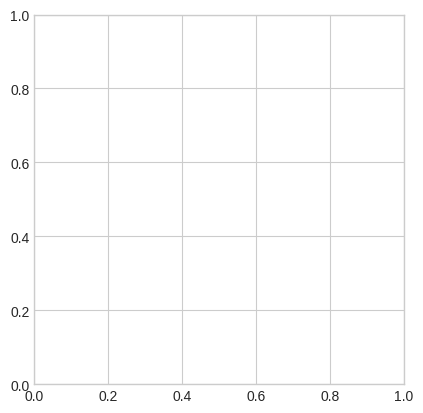

In [5]:
colorised_legend = colorise(
    flatten_labels(legend_tensor),
    "nipy_spectral",
    flatten=True,
)
# .permute(0, 2, 3, 1).squeeze(0)

plt.imshow(colorised_legend)

In [7]:
np.linspace(0, 1, 14).shape

(14,)

In [8]:
legend_tensor.shape

torch.Size([15, 1, 15])

In [9]:
type(flatten_labels(legend_tensor))

torch.Tensor

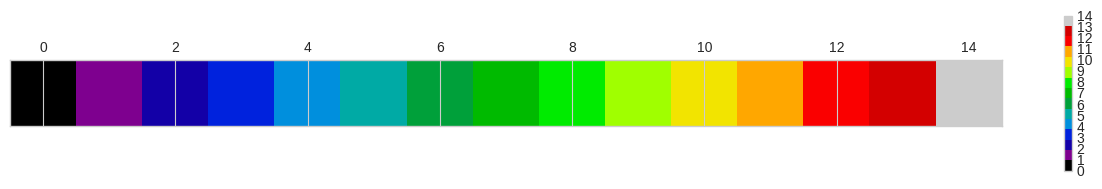

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def discrete_matshow(data):
    # get discrete colormap
    cmap = plt.get_cmap('nipy_spectral', 14 - 0 + 1)
    # set limits .5 outside true range
    mat = plt.matshow(data, cmap=cmap, vmin=0, vmax=14)
    # tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(0, 14 + 1))
    plt.yticks([])


# generate data
a = np.random.randint(1, 9, size=(10, 10))
discrete_matshow(flatten_labels(legend_tensor))



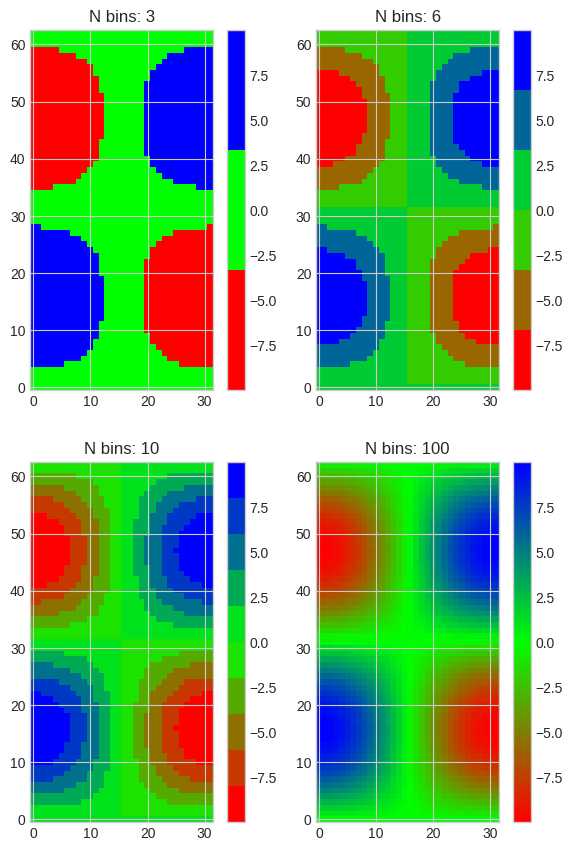

In [66]:
from matplotlib.colors import LinearSegmentedColormap


x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y) * 10

colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
fig, axs = plt.subplots(2, 2, figsize=(6, 9))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
for n_bin, ax in zip(n_bins, axs.flat):
    # Create the colormap
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, origin='lower', cmap=cmap)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im, ax=ax)

In [ ]:
colors = [
    
    (1, 0, 0), 
    (0, 1, 0), 
    (0, 0, 1)
]